# Analyze data frequency peaks using periodogram

Author: Damien Delforge, damien.delforge@uclouvain.be
Date: 09-03-2018


## What is a periodogram

Any integrable signal expressed in the time domain can be expressed into sums of sinusoidal components using Fourier series.
The components may have specific frequencies which stands for spectral signature of the signal or simply spectrum.
The process of transforming a signal from the time domain to its spectrum is called the Fourier transform.

In signal processing, a periodogram is an estimate of the power spectral density of a signal, i.e. the square of the absolute value of its spectrum. It helps identifying dominant frequencies in a signal



## Interpreting frequencies

|Period   |Frequency (Hz)|
|:-------:|:------------:|
| 1 s     | 1            |
| 1 min   | 1.67e-02     |
| 1 hour  | 2.78e-04     |
| 1 day   | 1.16e-05     |
| 30 day  | 3.86e-07     |
| 6 month | 6.34e-08     |
| 1 year  | 3.17e-08     |
| 10 years| 3.17e-09     |

## Import modules

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

## Load and visualize data

We load hourly discharge data from the Lhomme river (Rochefort, Belgium) into a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) from a csv file using the [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) method.

The first column of the file is a timestamp, the second is the streamflow discharge in cubic meter per seconds. Example:

    Timestamp, Discharge [cms]
    1968-12-31 23:00:00,2.618941396073
    1969-01-01 00:00:00,2.618941396073
    1969-01-01 01:00:00,2.618941396073
    1969-01-01 02:00:00,2.618941396073
    ...

The dataframe holds 175321 records.

In [2]:
df = pd.read_csv('data/discharge.csv', index_col = 0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175321 entries, 1968-12-31 23:00:00 to 1988-12-31 23:00:00
Data columns (total 1 columns):
Discharge [cms]    175321 non-null float64
dtypes: float64(1)
memory usage: 2.7 MB


In [3]:
discharge=df[df.columns[0]]
discharge.describe()

count    175321.000000
mean          4.288649
std           4.723853
min           0.150000
25%           1.227224
50%           2.793163
75%           5.587714
max          71.235717
Name: Discharge [cms], dtype: float64

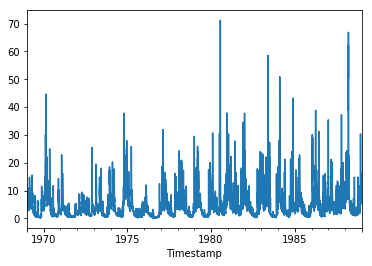

In [4]:
discharge.plot()

## Building a periodogram using numpy

1. We can use [np.fft.fft](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.fft.html#numpy.fft.fft) routine to perform the Fast Fourier Transform $F$ of the signal
2. We can compute the Power Spectral Density using $|F|^2$
3. We can use [np.fft.fftfreq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html) to return the FFT sampled frequencies 

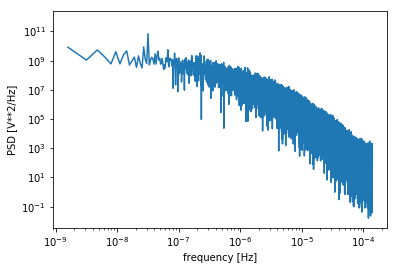

In [5]:
# compute power spectrum
ps = np.abs(np.fft.fft(discharge))**2
# define time step
time_step = 60*60 # 1 hour is 60 * 60 sec
# retrieve sampled frequencies
freqs = np.fft.fftfreq(discharge.values.size, time_step)
# get index of sorted frequencies in ascending order
idx = np.argsort(freqs)
# perform the plot
plt.loglog(freqs[idx], ps[idx])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

# storing plot limits for comparison
xlim = plt.xlim()
ylim = plt.ylim()

The left part of the periodogram correspond to low frequency cycles, while the right part corresponds to high frequency cycles.
The highest peaks is the annual seasonality (3.17e-08 Hz). We have at least 3 higher period cycles with one around 4e-09 Hz (7-8 years).

The right part is very noisy and difficult to interpret in terms of harmonics. The spreading tail in the log-log plot means that all the high frequencies are getting hit in the signal. It is usually considered as noise but it strictly means that there is no identifiable harmonic process at these frequencies. So it is either real noise or anharmonic, chaotic processes.

## Periodogram using scipy

The scipy module has a dedicated method [scipy.signal.periodogram](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html) to compute the periodogram. It is more straightforward.

(0.003391702223317904, 2688695984505.0269)

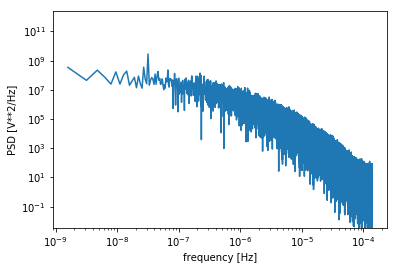

In [6]:
freq = 1./(60*60)
f, Pxx_den = signal.periodogram(discharge, freq)
plt.loglog(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(xlim)
plt.ylim(ylim)

## Periodogram using the Welch method

Welch’s method computes an estimate of the power spectral density by dividing the data into overlapping segments, computing a modified periodogram for each segment and averaging the periodograms. The number of data per segment is specified using the `nperseg` argument.

This method might show some improvement, especially with respect to noise immunity. However, it may hide some low frequency cycles.

It is implemented by the [scipy.signal.welch](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.welch.html#scipy.signal.welch) method.

The example below stacks 2 segments of the discharge data to compute the periodogram.

(0.003391702223317904, 2688695984505.0269)

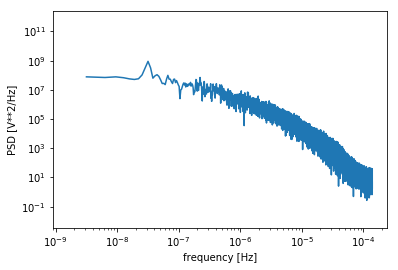

In [7]:
f, Pxx_den = signal.welch(discharge, freq, nperseg=len(discharge)/2)
plt.loglog(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(xlim)
plt.ylim(ylim)

Using Welch method makes the signal less noisy, but as mentioned before some long term cycles have disappeared. However, a 6 month cycle looks cleaner right after the annual peak as the whole spectrum in general thanks to the two periodogram averaging.

Use with caution.

## Using different scaling

Up to now, we used the `plt.loglog` method to visualize the periodogram. Other method are available to visualize the periodogram such as: `plt.plot`, `plt.semilogx` or `plot.semilogy`. Using these might be help full to identify other parts of the spectrum or when having a different dynamic.

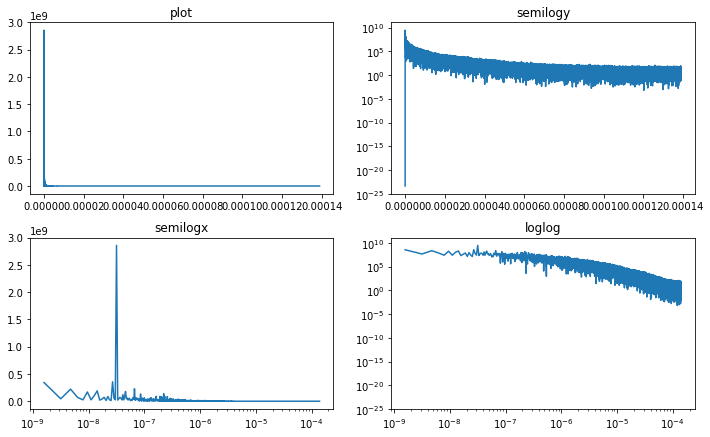

In [8]:
plt_methods = [plt.plot, plt.semilogy, plt.semilogx, plt.loglog]
f, Pxx_den = signal.periodogram(discharge, freq)

plt.figure(figsize=(10,10/1.618))
for i, plot in enumerate(plt_methods):
    ax = plt.subplot(2,2,i+1)
    ax.set_title(plot.__name__)
    plot(f, Pxx_den)
plt.tight_layout()

# Remarks

* These functions does not allow no-data in the original series. These should be either interplotlated or filled with a constant
* In case of no data or unevenly sampled time series a solution is to use the [Lomb-Scargle Periodogram method](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle) which is based on least square fitting of siniusoids. However, it requires much more computing power.